# CCMP Version 2 WSP binning data from January 1st, 1993 to December 31st, 2016

Plot figure within jupyter notebook

In [27]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
from datetime import datetime
import glob 
from scipy import signal
import cmocean.cm as cmo
from matplotlib import cm 

#my functions
from running_mean import running_mean
from save_binned_ccmp2_wsp import save_netcdf_fields

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the CCMP v2 data set, we want the following data orientation: 

In [4]:
#For one to one grid point comparison of ccmp v2 and Ifremer product 1:
#nt, nlon, nlat = 8766, 360, 133
#For climatological and least square fitting data analysis (the spatial and temporal scales can be the same):
nt, nlat, nlon = 8766, 529, 1440
initial_year = 1993
final_year = 2016
initial_mon = 1
final_mon = 12

Call CCMP version 2 data from the server using glob from January 1st, 1993 to December 31st, 2016 and sort them numerically with the sort function. Because the data is separated into yearly and monthly directories, I  will have to loop through all the years and months, in order obtain the names for all the files: 

In [5]:
#Initialize empty file to place all filenames into: 
filenames = []
#Initialize monthly time vector:
imonth = ['01','02','03','04','05','06','07','08','09','10','11','12']

#create year loop: 
for iyear in range(initial_year,final_year+1,1):
    
    #create month loop:
    #for imos in range(initial_mon,final_mon+1,1):
    for imos in imonth:
        
        #obtain filenames from all days within the directory: 
        files = sorted(glob.glob('/zdata/downloads/ccmp/v02.0/Y' + '%s' %iyear + '/M' + '%s' %imos + '/*_V02.0_L3.0_RSS.nc'))
        
        #concatinate all filenames into a list 
        filenames = filenames + files
#print(filenames)

Look at the name of the key variables in one of the files: 

In [6]:
#look at one file:
file = filenames[0]

#set nc variable in order to read attributes and obtained data: 
nc = Dataset(file, 'r')

#print key variables:
print(nc.variables.keys())

odict_keys(['longitude', 'latitude', 'time', 'uwnd', 'vwnd', 'nobs'])


Look at the dimensions of lon, lat, and time: 

In [7]:
#longitude
for at in nc.variables['longitude'].ncattrs():
    print("%s : %s" %(at, nc.variables['longitude'].getncattr(at)))

#laitude
for at in nc.variables['latitude'].ncattrs():
    print("%s : %s" %(at, nc.variables['latitude'].getncattr(at)))
    
#time 
for at in nc.variables['time'].ncattrs():
    print("%s : %s" %(at, nc.variables['time'].getncattr(at)))
#dimension: 
print('')
print(nc.variables['longitude'][:].shape,nc.variables['latitude'][:].shape)

standard_name : longitude
long_name : Longitude in degrees east
units : degrees_east
_Fillvalue : -9999.0
axis : X
valid_min : 0.125
valid_max : 359.875
_CoordinateAxisType : Lon
coordinate_defines : center
standard_name : latitude
long_name : Latitude in degrees north
units : degrees_north
_Fillvalue : -9999.0
axis : Y
valid_min : -78.375
valid_max : 78.375
_CoordinateAxisType : Lat
coordinate_defines : center
standard_name : time
long_name : Time of analysis
units : hours since 1987-01-01 00:00:00
delta_t : 000-00-00 06:00:00
avg_period : 
_Fillvalue : -9999.0
calendar : standard
axis : T
valid_min : 52608.0
valid_max : 52626.0
_CoordinateAxisType : Time

(1440,) (628,)


Set longitude and latitude vectors

In [8]:
#Call longitutde and latitude data:
lon = nc.variables['longitude'][:]
#lon = np.arange(0,360,0.25)
lat = nc.variables['latitude'][:]
#lat = np.arange(-78,79,0.25)

Set resolution of longitude and latitude. Also set the desired indices for where latitude will be truncated:

In [9]:
dlon = abs(lon[1]-lon[0])
dlat = abs(lat[1]-lat[0])
lat_min, lat_max = -66, 66 #extend the matrix to 66 north and south for latitude 

Loop through each of the filenames and complete the following: 

1)Compute wind speed from wind velocity components

2) Average each six hour time steps for each day (four time steps) 

3)Decrease the resolution of the data from 0.25 degree to 1 degree (I only need to do this when the data needs to be a one to one comparison with the Ifremer daily binned data) 

4)Make sure the orientation of longitude is pacific centered (this is true) and latitude ranges from -66 to 66

5)Place satellite tracks and continents into data set using the Ifremer product 1 data set ((I only need to do this when the data needs to be a one to one comparison with the Ifremer daily binned data) 

5)Bin wsp and time data 

Because each file is a separate day, I do not need to worry about making sure what file correspond to which day. In addition, recall the CCMP version 2 winds have data points at every grid point for all time steps because it is a product using multiple wind products and modelled data to produce a smooth grid through time and space. 

In [10]:
#initialize masked array to concatinate 2d arrays directly into a 3D array:
wsp_ccmp_d = np.ma.masked_all([nt, nlat, nlon])
time_d = []

#initialize counter:
i = 0
                                   
#call each data file separately from each day in order:
for f in filenames:
                                   
    #set nc variable in order to read attributes and obtained data: 
    nc = Dataset(f, 'r')

    #call corrected swh, corrected wsp, lon, and lat data from data file f: 
    uwnd = nc.variables['uwnd'][:]
    vwnd = nc.variables['vwnd'][:]
    time_i = num2date(nc.variables['time'][:], nc.variables['time'].units) #convert time directly into datetime format instead of integer value time 
    
    #compute wind speed: 
    wsp_h = np.sqrt((uwnd**2) + (vwnd**2))
    
    #print(wsp_h.shape)
    
    #Average the time steps from each day to obtain a daily average
    wsp_d = (wsp_h[0,:,:]+wsp_h[1,:,:]+wsp_h[2,:,:]+wsp_h[3,:,:])/4

    #decrease the resolution of the the wsp matrix via convolution: 
    #wsp_conv = running_mean(data = wsp_d, k_dim = [4,4]) #For one to one grid point comparison of ccmp v2 and Ifremer product 1
    
    #take only the data points from CCMP v2 which match with the along track satellite data points Ifremer:
    #wsp_along_track = land_fill(data = wsp_d, fill = 'Satellite', res = '1_deg') #For one to one grid point comparison of ccmp v2 and Ifremer product 1
    
    #truncate wsp data such that we are only looking at data from -66 to 66 degrees:
    trunc = abs(int((min(lat)-lat_min)/dlat))
    #wsp_c = wsp_conv[trunc:len(lat)-trunc,:] #For one to one grid point comparison of ccmp v2 and Ifremer product 1
    wsp_c = wsp_d[trunc:len(lat)-trunc-1,:]
    
    #bin wsp and time data (make sure that wsp_c is a masked array): 
    wsp_ccmp_d[i,:,:] = wsp_c
    time_d.append([time_i[0]])
    
    #counter sum 
    i = i + 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


KeyboardInterrupt: 

Make sure the truncation worked

In [11]:
print(trunc,len(lat)-trunc-1,lat[49],lat[579-1])
print(wsp_ccmp_d.shape)

49 578 -66.125 66.125
(8766, 529, 1440)


Reinitialize latitude vectors with new orientations and resolutions

In [12]:
lat_n = lat[trunc:len(lat)-trunc-1]

Save WSP, longitude, latitude, and time variables into yearly netCDF files (data is too larger for 0.25 resolution)

Create a loop to go through all the data year by year

In [25]:
#set year indices 
years = np.array([y[0].year for y in time_d])

#creat loop: 
for year in np.unique(years):
    
    #initialize the indices where the years vector elements are equal to the year value 
    ind_year = years == year
    
    #call wsp and time data for the given idices: 
    wsp_ccmp_y = wsp_ccmp_d[ind_year,:,:]
    
    #convert time to a numpy row vector: 
    time_c = np.array(time_d).reshape(1,len(time_d))[0]
    time_y = time_c[ind_year]
    
    #save data into a netCDF file:
    save_netcdf_fields(wsp = wsp_ccmp_y, lon = lon, lat = lat_n, time = time_y, output = '/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_' + '%s' %year + '_high_res.nc')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8766 but corresponding boolean dimension is 40

Check that data is properly binned 

(529, 1440)


Text(0.5, 1.0, 'Wind Speed on [datetime.datetime(1993, 1, 1, 0, 0)]')

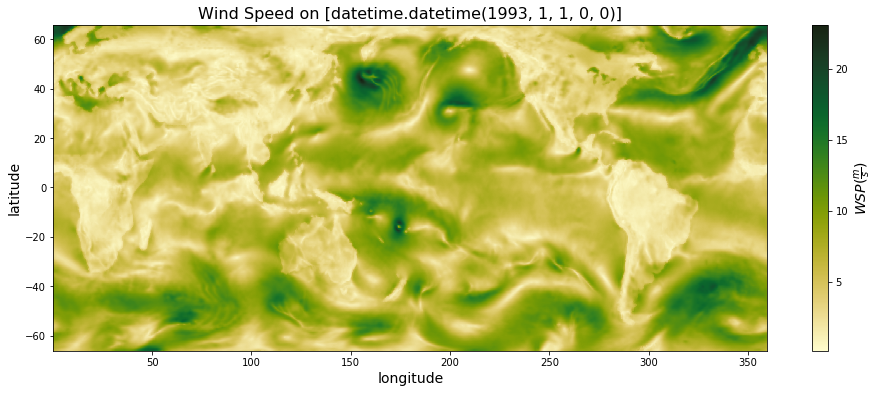

In [17]:
#set variables for ploting one time step of swh 
wsp_test = wsp_ccmp_d[0,:,:]
print(wsp_test.shape)
type(wsp_test)

#create figure and set figure size where figsize(width, length)
plt.figure(figsize=(16,6))
#plot a colormap of swh with contours with a colormap
#plt.contourf(lon,lat,swh_test,30)
plt.pcolor(lon,lat_n,wsp_test, cmap=cmo.speed) #or cmap=cm.
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label(r'$WSP(\frac{m}{s})$', fontsize=14)
#label figure 
title = time_d[0]
plt.title('Wind Speed on %s' %title,fontsize=16)

Check dimensions of data set 

In [75]:
print(len(time_d), len(lat), len(lon), wsp_ccmp_d.shape)

17 529 1440 (8766, 529, 1440)


### Development Code: 

In [80]:
fi = filenames[0]
#set nc variable in order to read attributes and obtained data: 
nc = Dataset(fi, 'r')

#call corrected swh, corrected wsp, lon, and lat data from data file f: 
uwnd = nc.variables['uwnd'][:]
vwnd= nc.variables['vwnd'][:]
time_i = num2date(nc.variables['time'][:], nc.variables['time'].units) #convert time directly into datetime format instead of integer value time 

print(uwnd.shape,vwnd.shape)

#compute wind speed: 
wsp_h = np.sqrt((uwnd**2) + (vwnd**2))

print(type(wsp_h[1,:,:]))



(4, 628, 1440) (4, 628, 1440)
<class 'numpy.ma.core.MaskedArray'>


In [81]:
np.set_printoptions(threshold=sys.maxsize)
t = np.array([(1,2,3,4,5,6,7,8),(1,2,3,4,5,6,7,8),(1,2,3,4,5,6,7,8),(1,2,3,4,5,6,7,8)])
k = np.array([(1,1,1,1),(1,1,1,1),(1,1,1,1),(1,1,1,1)])
k = k/np.sum(k)
#print(t)
#print(k)
test = signal.convolve2d(t,k)
print(test)
print('')
print(test[3::4,3::4])


[[0.0625 0.1875 0.375  0.625  0.875  1.125  1.375  1.625  1.3125 0.9375
  0.5   ]
 [0.125  0.375  0.75   1.25   1.75   2.25   2.75   3.25   2.625  1.875
  1.    ]
 [0.1875 0.5625 1.125  1.875  2.625  3.375  4.125  4.875  3.9375 2.8125
  1.5   ]
 [0.25   0.75   1.5    2.5    3.5    4.5    5.5    6.5    5.25   3.75
  2.    ]
 [0.1875 0.5625 1.125  1.875  2.625  3.375  4.125  4.875  3.9375 2.8125
  1.5   ]
 [0.125  0.375  0.75   1.25   1.75   2.25   2.75   3.25   2.625  1.875
  1.    ]
 [0.0625 0.1875 0.375  0.625  0.875  1.125  1.375  1.625  1.3125 0.9375
  0.5   ]]

[[2.5 6.5]]


In [82]:
0.0625 + 2*0.0625 + 3*0.0625

0.375

In [83]:
628/4

157.0

In [91]:
#kernal matrix:
w = np.array([(1,1,1,1),(1,1,1,1),(1,1,1,1),(1,1,1,1)])
#normalize kernal matrix: 
w = w/np.sum(w)
#convolve image matrix with kernal matrix: 
wsp_conv = signal.convolve2d(wsp_d,w)
#select the elements from the convolved wsp matrix that are the averaged of four element boxes that do not overlap with each other and the edges of the matrix:
#Code below reads: take every four element begining at position 3 (0,1,2,3) and continuing till the end
wsp_c = wsp_conv[3::4,3::4]


In [84]:
print(filenames[30],filenames[31])

/zdata/downloads/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930131_V02.0_L3.0_RSS.nc /zdata/downloads/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930201_V02.0_L3.0_RSS.nc


In [85]:
print(wsp_ccmp_d.shape)
print(wsp_c.shape)
time_d[-1]

(8766, 529, 1440)
(529, 1440)


[datetime.datetime(1993, 1, 17, 0, 0)]

In [86]:
#initialize empty array
wsp_ccmp_d2 = np.ma.masked_all([8766, nlat, nlon])

#create loop to re-concatinate all wsp daily 2d arrays
for iday in range(0,8766):
    if iday <= 8764:
        wsp_ccmp_d2[iday,:,:] = wsp_ccmp_d[iday,:,:]
    elif iday == 8765:
        wsp_ccmp_d2[iday,:,:] = wsp_c
print(wsp_ccmp_d2.shape)


(8766, 529, 1440)


In [87]:
print(time_i[0])
time_d.append([time_i[0]])

1993-01-01 00:00:00


In [88]:
len(time_d)


18

In [89]:
print(min(lat))
print((int(min(lat))-lat_min)/dlat)
print((-78-(-66))/1)

-66.125
0.0
-12.0


In [90]:
157-12

145

In [25]:
print(time_i)
years = np.array([y.years for y in time_i])
print(k)

[datetime.datetime(2016, 12, 31, 0, 0)
 datetime.datetime(2016, 12, 31, 6, 0)
 datetime.datetime(2016, 12, 31, 12, 0)
 datetime.datetime(2016, 12, 31, 18, 0)]


AttributeError: 'datetime.datetime' object has no attribute 'years'

In [27]:
month_data = {}
type(month_data)

dict

In [8]:
year = 1993

output = '/zdata/home/lcolosi/data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_' + '%s' %year + '_high_res.nc'
print(output)


/zdata/home/lcolosi/data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1993_high_res.nc


In [ ]:
#look if there is any nan values in the 2D array
imask = wsp_c == wsp_c.mask
#ival = ~np.isnan(wsp_c)

print(len(wsp_c[~imask]), len(wsp_c[imask]), len(wsp_c), 529*1440)
print(imask)

In [24]:
test_i = time_d
test_f = np.array([y[0].year for y in test_i])
print(test_f)

[1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993
 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993
 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993 1993]


In [38]:
print(ind_year)
time_c = np.array(time_d).reshape(1,len(time_d))[0]
print(time_c[ind_year])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[datetime.datetime(1993, 1, 1, 0, 0) datetime.datetime(1993, 1, 2, 0, 0)
 datetime.datetime(1993, 1, 3, 0, 0) datetime.datetime(1993, 1, 4, 0, 0)
 datetime.datetime(1993, 1, 5, 0, 0) datetime.datetime(1993, 1, 6, 0, 0)
 datetime.datetime(1993, 1, 7, 0, 0) datetime.datetime(1993, 1, 8, 0, 0)
 datetime.datetime(1993, 1, 9, 0, 0) datetime.datetime(1993, 1, 10, 0, 0)
 datetime.datetime(1993, 1, 11, 0, 0) datetime.datetime(1993, 1, 12, 0, 0)
 datetime.datetime(1993, 1, 13, 0, 0) datetime.datetime(1993, 1, 14, 0, 0)
 datetime.datetime(1993, 1, 15, 0, 0) datetime.datetime(1993, 1, 16, 0, 0)
 datetime.datetime(1993, 1, 17, 0, 0) datetime.datetime(1993, 1, 18, 0, 0)
 datetime.datetime(1993, 1, 19, 0, 0) datetime.datetime(1993, 1, 20, 0, 0)
 datetime.date